## Q-learning / Reinforcement learning, example 4, FrozenLake, what happens if the environment is a dead-end?

#### Imports + and make the environment

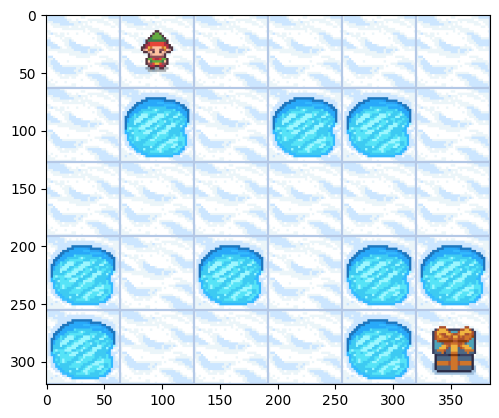

In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

# define a custom map, S => start, G => goal, F => normal ice tile, H => hole 
custom_map = ["FSFFFF",
              "FHFHHF",
              "FFFFFF",
              "HFHFHH",
              "HFFFHG"]


# create the FrozenLake environment, DISABLE SLIPPERY
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array", desc=custom_map)

# it would be logical to have width + height
# we have to double-check that we get the correct values in this order 
grid_height, grid_width  = env.unwrapped.desc.shape

# documentation for this environment:
# https://gymnasium.farama.org/environments/toy_text/frozen_lake/

env.reset()
plt.imshow(env.render())

In [ ]:
# Here I checked there is dead end and Agent is unable to learn 
# Q-values remain near zero, and the agent doesn't update meaningful policies.
#After training, you'll likely see mostly zeros, except for random noise—indicating the agent couldn't find value in most states

### This time, we'll use Q-learning and reinforcement learning for the agent (elf) to move in the world!

In [2]:
# let's inspect the environment
print("Observation space:")
print(env.observation_space)

print("\nAction space:")
print(env.action_space)

# in other words observation space => 4 x 4 grid => 16 cells
# action space => 4 different movements are possible => up, right, down, left

Observation space:
Discrete(30)

Action space:
Discrete(4)


In [3]:
# the above information is used to generate an EMPTY Q-table!
# basically Q-table will hold the Quality-values (Q-values) for each possible action
# for each possible cell in the grid (basically we map out all possibilities in this environment)
Q_table = np.zeros([env.observation_space.n, env.action_space.n])
Q_table.shape

(30, 4)

## Q-learning formula:

#### Q(s, a) = Q(s, a) + alpha * (r + y * max(Q(s', a')) - Q(s, a))

In [4]:
# let's code the above equation into Q-learning update -function
def calculate_value(Q, state, action, reward, next_state, alpha, gamma):
    Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
    return Q

### Helper function to visualize the highest Q-values in the grid

In [5]:
def summarize_best_values(q_table, grid_width, grid_height):
    # get a list of highest values for each cell
    best_values = np.max(q_table, axis=1)

    # reshape into matrix that is the same shape as the environment
    return best_values.reshape(grid_height, grid_width)

In [ ]:
# Here I checked there is dead end and Agent is unable to learn 
#  Q-values remain near zero, and the agent doesn't update meaningful policies.
#After training, you'll likely see mostly zeros, except for random noise—indicating the agent couldn't find value in most states


In [ ]:


total_episodes = 10000

max_steps = 50

learning_rate = 0.5
gamma = 0.9

epsilon = 0.9

max_epsilon = 0.9

min_epsilon = 0.01
decay_rate = 0.0005

### Train the agent with a for-loop (based on episodes)

#### NOTE! This grid is already much more complex, and a simple policy where we only use the +1 reward for goal is not going to cut, we need to fine-tune the policy

In [7]:
# "play" the game for the amount episodes defined
for episode in range(total_episodes):
    # Gymnasium environments usually have to be reset before training
    # => we get initial state + info-variable (info is not required usually)
    state, info = env.reset()

    # in the beginning of the game, the game is not over
    # the game is done either by falling into a hole or finding the goal
    done = False

    # in the beginning of the game, our total_rewards are 0
    total_rewards = 0

    # WITHIN this episode of playing the game, play as long as our max steps define
    # (this example: give up after 50 steps -> probably not optimal route)
    for step in range(max_steps):
        # this is what we need to do:

        # PHASE 1: determine the next action!
        # use epsilon to decide whether we should trust previous knowledge
        # or take a wild guess
        # epsilon -> should we EXPLOIT our current knowledge or explore (wild guess)
        if np.random.uniform(0, 1) > epsilon:
            # use exploitation in this case => use best known action for this cell!
            action = np.argmax(Q_table[state, :])
        else:
            # let's explore => random action
            action = env.action_space.sample()


        # PHASE 2: get the results from the action done in PHASE 1
        # and unpack the results into: observation, reward, done
        observation, reward, done, truncated, info = env.step(action)

        # PHASE 3.1 -> punish the agent for making a move -> a very small adjustment
        # this will eventually guide the agent to choose the shortest path with least moves
        reward = reward - 0.01

        # PHASE 3.2 => if the agent drops into a hole => PUNISH HEAVILY
        # basically if game over is true and reward is 0 or less => game over with hole
        # if agent drops into a hole, we just adjust the reward accordingly, and stop this episode
        if done and reward <= 0:
            reward = -1
            Q_table = calculate_value(Q_table, state, action, reward, observation, learning_rate, gamma)
            total_rewards = total_rewards + reward
            break
            
        # PHASE 3.3: update the Q-table with the values we have right now
        # NOTE: this phase will be skipped if the agent dropped down a hole in previous section
        Q_table = calculate_value(Q_table, state, action, reward, observation, learning_rate, gamma)

        # PHASE 4: save current state and update rewards
        state = observation
        total_rewards = total_rewards + reward

        # PHASE 5: check if we have either lost or won the game
        if done:
            print(f"Steps taken: {step}")

            # # little bit of debugging of the current version of the Q-table
            # if total_rewards > 0 and step % 6 == 0:
            #     print(f"Current Q-table - Episode: {episode}")
            #     print(summarize_best_values(Q_table, grid_width, grid_height))
            #     print()

            break

    # FINAL PHASE: AFTER THE EPISODE -> apply decay to epsilon
    # instead of linear decay, we have an expontential curve
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)

    # only print the result if our rewards are positive
    if total_rewards >= 0:
        print(f"Episode {episode} done with total rewards: {total_rewards}, epsilon: {epsilon}")

### Let's study the final optimal Q-table for our grid

In [8]:
# the raw Q-table is a bit hard to read for us, since for each cell we have a different value 
# for each action
Q_table

# each list in each row is one cell in the grid
# each value in a list is the quality of action based on:
# 0: Move left, 1: Move down, 2: Move right, 3: Move up
# so in the first row best values are 1 and 2 => basically it doesn't matter
# if we go down or right from the first cell

# however, this is quite hard to visualize already, see the next version below

array([[-0.1, -0.1, -0.1, -0.1],
       [-0.1, -1. , -0.1, -0.1],
       [-0.1, -0.1, -0.1, -0.1],
       [-0.1, -1. , -0.1, -0.1],
       [-0.1, -1. , -0.1, -0.1],
       [-0.1, -0.1, -0.1, -0.1],
       [-0.1, -0.1, -1. , -0.1],
       [ 0. ,  0. ,  0. ,  0. ],
       [-1. , -0.1, -1. , -0.1],
       [ 0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ],
       [-1. , -0.1, -0.1, -0.1],
       [-0.1, -1. , -0.1, -0.1],
       [-0.1, -0.1, -0.1, -1. ],
       [-0.1, -1. , -0.1, -0.1],
       [-0.1, -0.1, -0.1, -1. ],
       [-0.1, -1. , -0.1, -1. ],
       [-0.1, -1. , -0.1, -0.1],
       [ 0. ,  0. ,  0. ,  0. ],
       [-1. , -0.1, -1. , -0.1],
       [ 0. ,  0. ,  0. ,  0. ],
       [-1. , -0.1, -1. , -0.1],
       [ 0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ],
       [-1. , -0.1, -0.1, -0.1],
       [-0.1, -0.1, -0.1, -1. ],
       [-0.1, -0.1, -1. , -0.1],
       [ 0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ]])

In [9]:
# ... we need a helper function for this!
# 0: Move left, 1: Move down, 2: Move right, 3: Move up
results = summarize_best_values(Q_table, grid_width, grid_height)

df = pd.DataFrame(results)
df

# compare the summarized best values grid to the actual grid below

,0,1,2,3,4,5
0,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1
1,-0.1,0.0,-0.1,0.0,0.0,-0.1
2,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1
3,0.0,-0.1,0.0,-0.1,0.0,0.0
4,0.0,-0.1,-0.1,-0.1,0.0,0.0


## Notice how the Q-values are inverted when the environment is unsolvable.

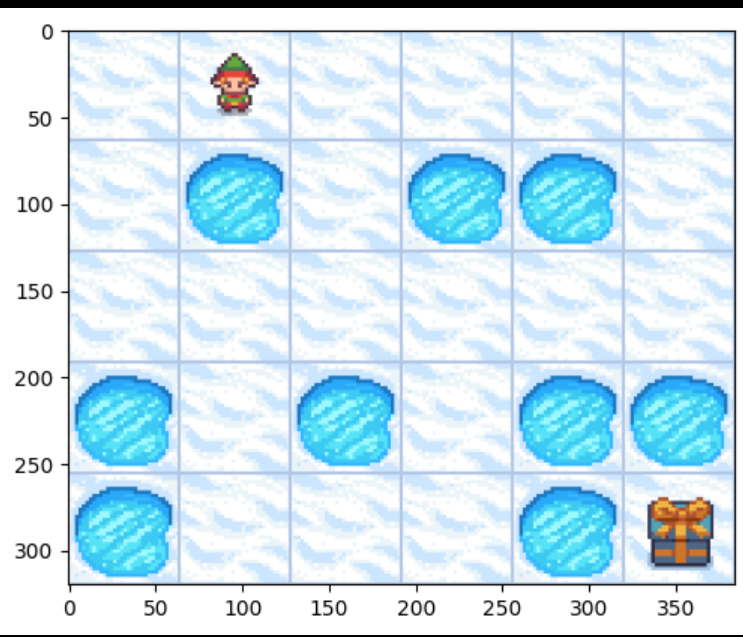

### Finally, let's allow our Q-learning -based AI to play the game with the optimized Q-table!

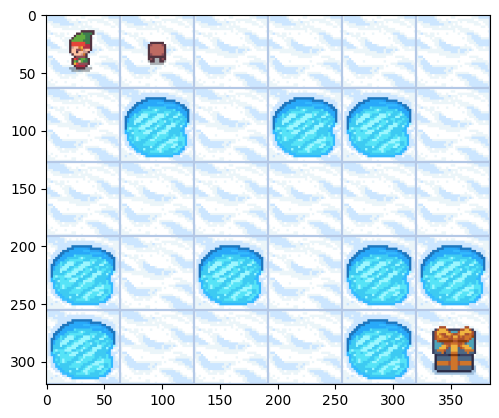

In [ ]:
# let's use now the Q-table (agent) we have for this environment
# => play the game based on the Q-table but only using exploitation

env.reset()
clear_output(wait=True)
plt.imshow(env.render())
plt.show()

# for-loop => allow the agent to play this 5 times in a row (5 episodes)
for episode in range(5):
    state, info = env.reset()
    done = False
    total_rewards = 0

    # play for the max number of steps
    for step in range(max_steps):
        # take the best action for this situation from the Q-table
        # basically based on the current cell => choose the best action we have calculated
        # in the Q-table during training

        # an idea for the exercise project:
        # => if multiple identical high values => choose a random path
        action = np.argmax(Q_table[state, :])

        # unpack the results
        observation, reward, done, truncated, info = env.step(action)

        # update total rewards
        total_rewards = total_rewards + reward

        # update the visual frame
        clear_output(wait=True)
        plt.imshow(env.render())
        plt.show()

        # if we are game over either by hole or goal => break the loop
        if done:
            print(f"Episode: {episode + 1} done with total_rewards: {total_rewards}")
            time.sleep(2)
            break

        # save new state as old state, continue with next step
        state = observation
        time.sleep(0.3)

### Well done ELF (again)!